## Tutorial 4: Time Series Forecasting with LSTM

In this tutorial, we provide a PyTorch experiment of LSTM following: https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!nvidia-smi

Sun Jul 14 22:08:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import torch
import pickle


######################################################################
assert os.getcwd() == "/content"
dir_name = ".../data/data/"
file_names = os.listdir(dir_name)
TICKERS = [None] * len(file_names)
start_date, end_date = None, None
# extract tickers
for k in range(len(file_names)):
    tmp = file_names[k].split("_")
    tk = tmp[0]
    if start_date is None:
        start_date = tmp[1]
    if end_date is None:
        end_date = tmp[-1].split(".")[0]
    TICKERS[k] = tk
print("> Date range = {} TO {}".format(start_date, end_date))
print("> Tickers = {}".format(TICKERS))
n = len(TICKERS)
price_data = {}
for k in range(n):
    tk = TICKERS[k]
    fname = file_names[k]
    # load data
    tmp = dir_name + "/" + fname
    data = pd.read_csv(tmp)
    assert not data.isnull().values.any()
    # use adjusted close and slice to 2021-04-30
    date = data["Date"][:1512]
    price = data["Adj Close"][:1512]
    if k == 0:
      print("> Actual date range = {} TO {}".format(date.min(), date.max()))
    # compute price changes
    price_data[tk] = (
        date, price
    )

> Date range = 2015-04-30 TO 2024-04-30
> Tickers = ['AAPL', 'INTC', 'GOOG', 'AMZN', 'MSFT', 'ADBE', 'TCEHY', 'NVDA', 'META', 'CSCO', 'ORCL', 'QCOM', 'TSM', 'CRM', 'BABA', 'AVGO', 'TSLA', 'IBM']
> Actual date range = 2015-04-30 TO 2021-04-30


In [ ]:
# train-test split for time series
timeseries = price_data["NVDA"][1]
train_size = int(len(timeseries) * 0.60)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

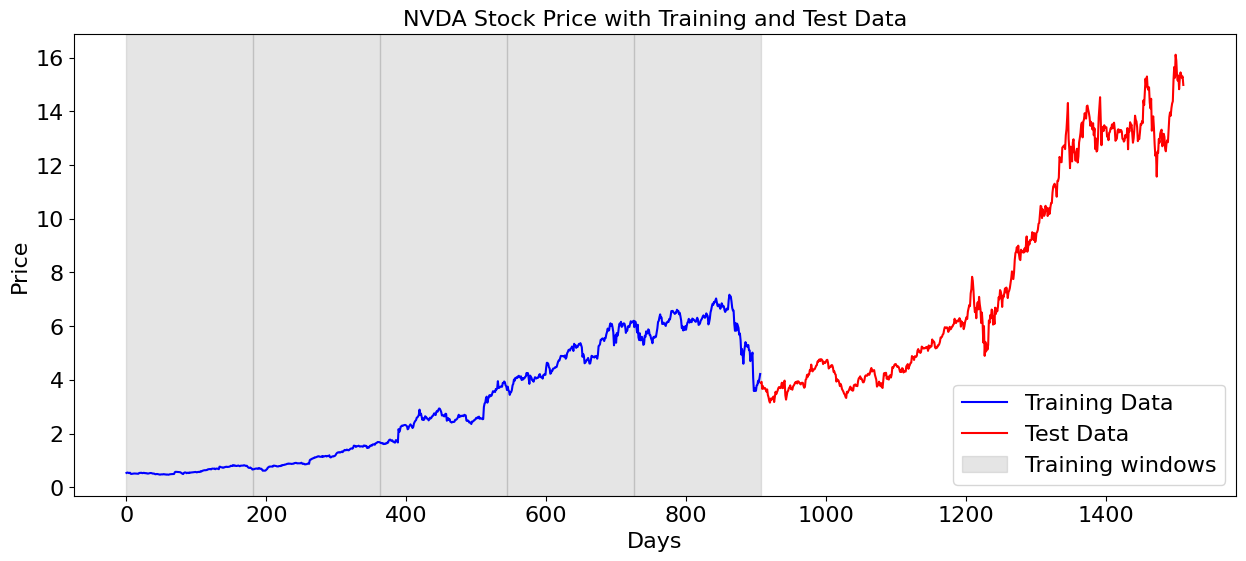

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))

# Plot the training data in blue
plt.plot(train, color="blue", label="Training Data")

# Plot the test data in red
plt.plot(test, color="red", label="Test Data")

# Create shaded areas for the windows in the training data
for i in range(5):
    start_index = int(i * train_size / 5)
    end_index = int((i + 1) * train_size / 5)
    if i == 0:
      plt.axvspan(start_index, end_index, alpha=0.2, color="gray", label="Training windows")
    else:
      plt.axvspan(start_index, end_index, alpha=0.2, color="gray", label="")

# Add a legend and title
plt.legend(fontsize=16)
plt.title("NVDA Stock Price with Training and Test Data", fontsize=16)
plt.xlabel("Days", fontsize=16);
plt.ylabel("Price", fontsize=16);
plt.xticks(fontsize=16); plt.yticks(fontsize=16);
plt.savefig("./nvda_training_data.png", dpi=200);

## Base LSTM

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

class BasicLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).float().reshape([-1, lookback, 1]), torch.tensor(y).float().reshape([-1, lookback, 1])


n_epochs = 500
for ticker in TICKERS:
    # create new model
    model = BasicLSTM()
    # training and batching setup
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    # train-test split for time series of ticker
    timeseries = price_data[ticker][1]
    train_size = int(len(timeseries) * 0.60)
    test_size = len(timeseries) - train_size
    train, test = timeseries[:train_size], timeseries[train_size:]

    # create batched data set
    lookback = 10
    X_train, y_train = create_dataset(train.values, lookback=lookback)
    X_test, y_test = create_dataset(test.values, lookback=lookback)
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
    print("> Model for {} created".format(ticker))

    # Train the model
    train_error = []
    test_error = []
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()

        for X_batch, y_batch in loader:
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        if epoch % 10 != 0:
          continue
        model.eval()
        with torch.no_grad():
          y_pred = model(X_train)
          train_rmse = np.sqrt(loss_fn(y_pred, y_train))
          y_pred = model(X_test)
          test_rmse = np.sqrt(loss_fn(y_pred, y_test))
          print("Stock = %s, Epoch %d: train RMSE %.4f, test RMSE %.4f" % (ticker, epoch, train_rmse, test_rmse))
        train_error.append(train_rmse.item())
        test_error.append(test_rmse.item())
    # Save the model and errors after training
    with open(f".../models/loss/{ticker}_BasicLSTM_train.pkl", 'wb') as f:
        pickle.dump(train_error, f)
    with open(f".../models/loss/{ticker}_BasicLSTM_test.pkl", 'wb') as f:
        pickle.dump(test_error, f)
    print("Loss Information Saved")

    # Save the model weights
    torch.save(model.state_dict(), f".../models/{ticker}_BasicLSTM.pt")

# save train and test errors



<ipython-input-8-198b48381c8e>:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X).float().reshape([-1, lookback, 1]), torch.tensor(y).float().reshape([-1, lookback, 1])


> Model for AAPL created
Stock = AAPL, Epoch 0: train RMSE 27.7964, test RMSE 78.2444
Stock = AAPL, Epoch 10: train RMSE 5.8034, test RMSE 52.5580
Stock = AAPL, Epoch 20: train RMSE 2.4340, test RMSE 45.1930
Stock = AAPL, Epoch 30: train RMSE 1.4396, test RMSE 41.6379
Stock = AAPL, Epoch 40: train RMSE 1.1050, test RMSE 39.4021
Stock = AAPL, Epoch 50: train RMSE 0.8934, test RMSE 37.3590
Stock = AAPL, Epoch 60: train RMSE 0.7489, test RMSE 35.4930
Stock = AAPL, Epoch 70: train RMSE 0.6165, test RMSE 33.6246
Stock = AAPL, Epoch 80: train RMSE 0.6111, test RMSE 32.0663
Stock = AAPL, Epoch 90: train RMSE 0.5716, test RMSE 30.8342
Stock = AAPL, Epoch 100: train RMSE 0.5470, test RMSE 30.1162
Stock = AAPL, Epoch 110: train RMSE 0.5437, test RMSE 29.7694
Stock = AAPL, Epoch 120: train RMSE 0.5165, test RMSE 29.5513
Stock = AAPL, Epoch 130: train RMSE 0.5523, test RMSE 29.4605
Stock = AAPL, Epoch 140: train RMSE 0.5357, test RMSE 29.5558
Stock = AAPL, Epoch 150: train RMSE 0.5247, test RMSE 2

In [ ]:
# test loading loss information
with open(f".../models/loss/AAPL_BasicLSTM_test.pkl", 'rb') as f:
    test = pickle.load(f)

In [ ]:
# test loading model
model = BasicLSTM()
model.load_state_dict(torch.load(f".../models/AAPL_BasicLSTM.pt"))
test_pred = model(X_train)
print(test_pred.sum())

tensor(554608.0625, grad_fn=<SumBackward0>)


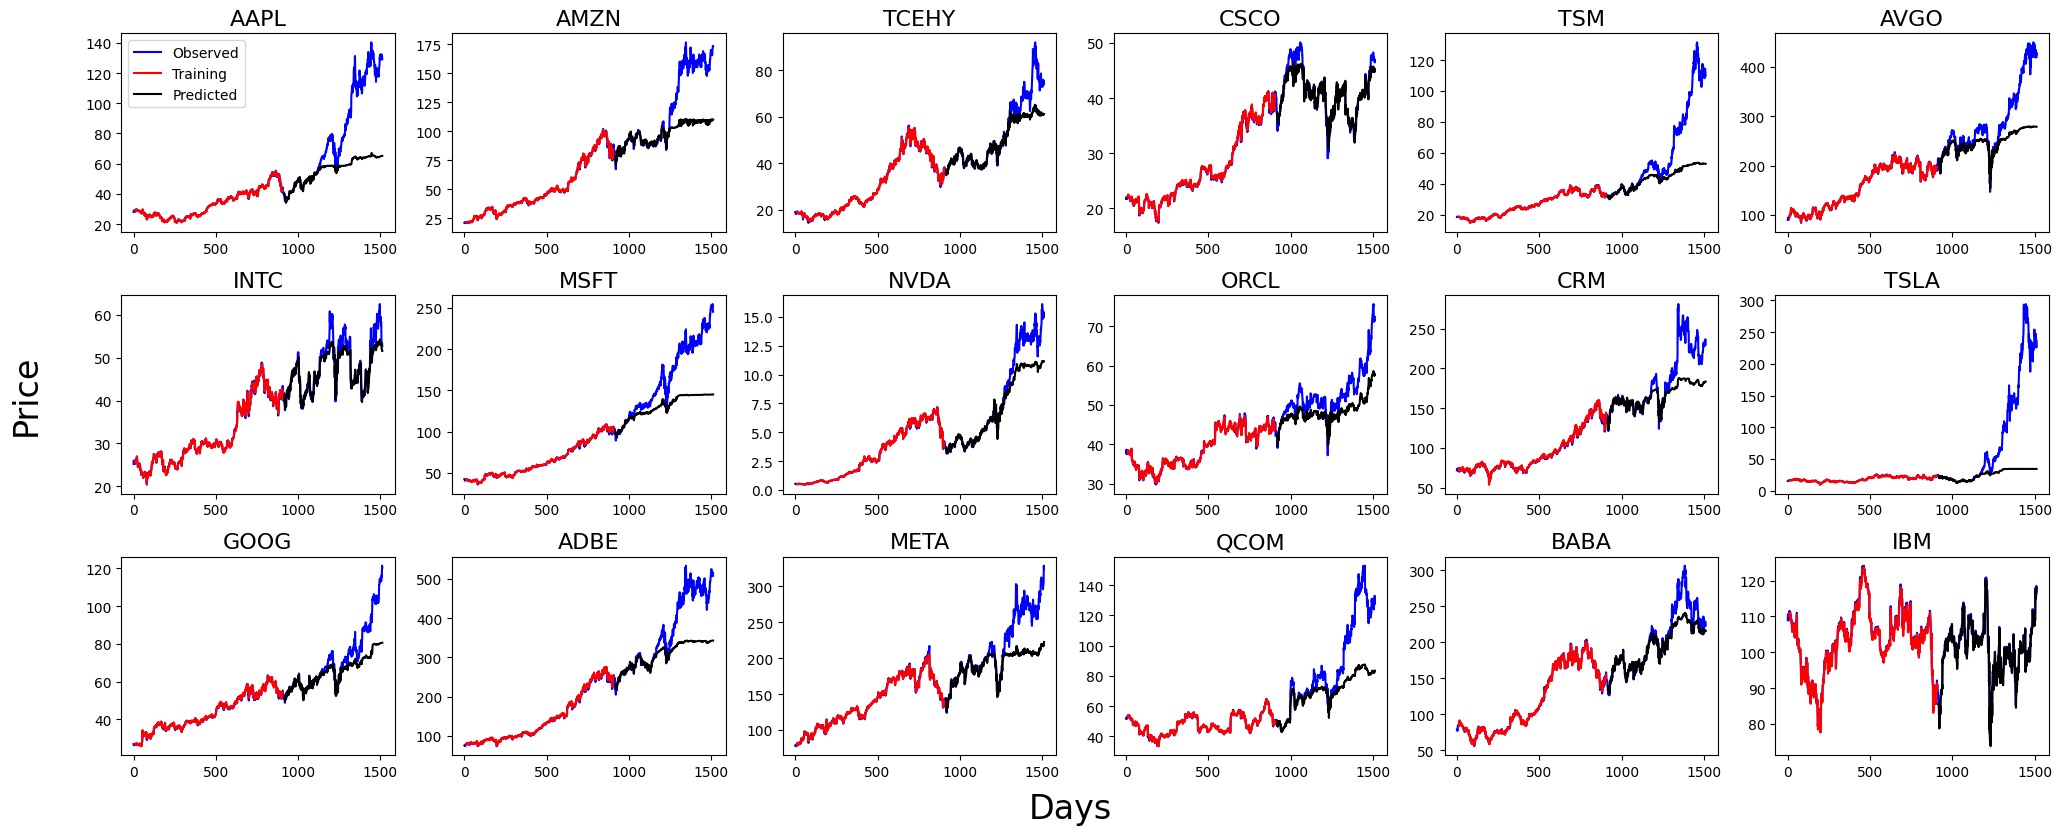

In [ ]:
nrow = 3
ncol = 6

fig, ax = plt.subplots(nrow, ncol, figsize=(20, 8))

for k in range(len(TICKERS)):
  ticker = TICKERS[k]
  r, c = k % nrow, k // nrow
  timeseries = price_data[ticker][1]
  # create training data again
  train_size = int(len(timeseries) * 0.60)
  test_size = len(timeseries) - train_size
  train, test = timeseries[:train_size], timeseries[train_size:]
  lookback = 10
  X_train, y_train = create_dataset(train.values, lookback=lookback)
  X_test, y_test = create_dataset(test.values, lookback=lookback)
  model = BasicLSTM()
  model.load_state_dict(torch.load(f".../models/{ticker}_BasicLSTM.pt"))
  # Use the model for prediction or other tasks
  with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :].flatten()
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :].flatten()
    # plot
    if k == 0:
        ax[r, c].plot(timeseries, c='b', label="Observed")
        ax[r, c].plot(train_plot, c='r', label="Training")
        ax[r, c].plot(test_plot, c='black', label="Predicted")
        ax[r, c].legend();
    else:
        ax[r, c].plot(timeseries, c='b', label="Observed")
        ax[r, c].plot(train_plot, c='r', label="Training")
        ax[r, c].plot(test_plot, c='black', label="Predicted")
    ax[r, c].set_title(ticker, fontsize=16);
fig.tight_layout()
fig.text(0.5, -0.03, 'Days', ha='center', fontsize=24)
fig.text(-0.03, 0.5, 'Price', va='center', rotation='vertical', fontsize=24)
fig.savefig("./base_lstm.png", dpi=200, bbox_inches="tight")

## Stacked LSTM

In [ ]:
class StackedLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=50, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.linear(x)
        return x
# train on TSLA data only
n_epochs = 500
for ticker in ["TSLA"]:
    # create new model
    model = StackedLSTM()
    # training and batching setup
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    # train-test split for time series of ticker
    timeseries = price_data[ticker][1]
    train_size = int(len(timeseries) * 0.60)
    test_size = len(timeseries) - train_size
    train, test = timeseries[:train_size], timeseries[train_size:]

    # create batched data set
    lookback = 10
    X_train, y_train = create_dataset(train.values, lookback=lookback)
    X_test, y_test = create_dataset(test.values, lookback=lookback)
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
    print("> Model for {} created".format(ticker))

    # Train the model
    train_error = []
    test_error = []
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()

        for X_batch, y_batch in loader:
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        if epoch % 10 != 0:
          continue
        model.eval()
        with torch.no_grad():
          y_pred = model(X_train)
          train_rmse = np.sqrt(loss_fn(y_pred, y_train))
          y_pred = model(X_test)
          test_rmse = np.sqrt(loss_fn(y_pred, y_test))
          print("Stock = %s, Epoch %d: train RMSE %.4f, test RMSE %.4f" % (ticker, epoch, train_rmse, test_rmse))
        train_error.append(train_rmse.item())
        test_error.append(test_rmse.item())
    # Save the model and errors after training
    with open(f".../models/loss/{ticker}_StackedLSTM_train.pkl", 'wb') as f:
        pickle.dump(train_error, f)
    with open(f".../models/loss/{ticker}_StackedLSTM_test.pkl", 'wb') as f:
        pickle.dump(test_error, f)
    print("Loss Information Saved")

    # Save the model weights
    torch.save(model.state_dict(), f".../models/{ticker}_StackedLSTM.pt")


> Model for TSLA created
Stock = TSLA, Epoch 0: train RMSE 10.1874, test RMSE 110.6456
Stock = TSLA, Epoch 10: train RMSE 3.9204, test RMSE 104.6696
Stock = TSLA, Epoch 20: train RMSE 3.9143, test RMSE 104.7555
Stock = TSLA, Epoch 30: train RMSE 3.9152, test RMSE 104.6252
Stock = TSLA, Epoch 40: train RMSE 3.9095, test RMSE 104.7357
Stock = TSLA, Epoch 50: train RMSE 3.9076, test RMSE 104.7109
Stock = TSLA, Epoch 60: train RMSE 3.9059, test RMSE 104.7544
Stock = TSLA, Epoch 70: train RMSE 3.9062, test RMSE 104.8084
Stock = TSLA, Epoch 80: train RMSE 1.2855, test RMSE 101.7182
Stock = TSLA, Epoch 90: train RMSE 1.2836, test RMSE 101.5360
Stock = TSLA, Epoch 100: train RMSE 1.2931, test RMSE 101.5377
Stock = TSLA, Epoch 110: train RMSE 1.2839, test RMSE 101.5102
Stock = TSLA, Epoch 120: train RMSE 0.6874, test RMSE 99.8955
Stock = TSLA, Epoch 130: train RMSE 0.5704, test RMSE 99.2144
Stock = TSLA, Epoch 140: train RMSE 0.5195, test RMSE 99.6688
Stock = TSLA, Epoch 150: train RMSE 0.5173,

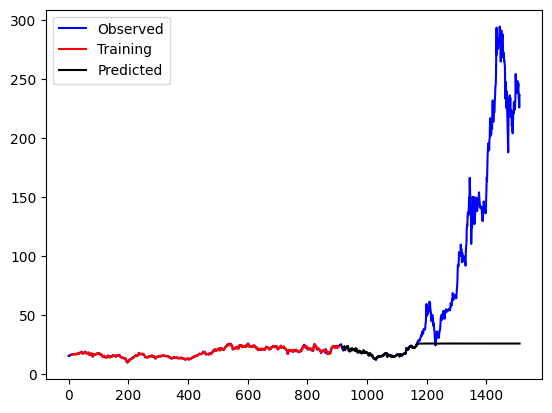

In [ ]:
# plotting
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :].flatten()
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :].flatten()
# plot
plt.plot(timeseries, c='b', label="Observed")
plt.plot(train_plot, c='r', label="Training")
plt.plot(test_plot, c='black', label="Predicted")
plt.legend();
plt.show()


## Stacked Ensemble LSTM

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
class BaggingLSTM(nn.Module):
    def __init__(self, num_models):
        super().__init__()
        self.num_models = num_models
        self.lstms = nn.ModuleList([BasicLSTM() for _ in range(num_models)])
        self.linear = nn.Linear(num_models, 1)
    def forward(self, x):
        outputs = []
        for lstm in self.lstms:
            outputs.append(lstm(x))
        outputs = torch.stack(outputs, dim=1)
        # permute dimensions to expose to the linear layer application
        #print(outputs.shape)
        outputs = torch.permute(outputs, (0, 2, 3, 1))
        outputs = self.linear(outputs)
        outputs = outputs.squeeze(3)
        return outputs

# train on TSLA data only
n_epochs = 500
for ticker in ["TSLA"]:
    # create new model
    model = BaggingLSTM(num_models=5)
    # training and batching setup
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    # train-test split for time series of ticker
    timeseries = price_data[ticker][1]
    train_size = int(len(timeseries) * 0.60)
    test_size = len(timeseries) - train_size
    train, test = timeseries[:train_size], timeseries[train_size:]

    # create batched data set
    lookback = 10
    X_train, y_train = create_dataset(train.values, lookback=lookback)
    X_test, y_test = create_dataset(test.values, lookback=lookback)
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
    print("> Model for {} created".format(ticker))

    # Train the model
    train_error = []
    test_error = []
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()

        for X_batch, y_batch in loader:
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        if epoch % 10 != 0:
          continue
        model.eval()
        with torch.no_grad():
          y_pred = model(X_train)
          train_rmse = np.sqrt(loss_fn(y_pred, y_train))
          y_pred = model(X_test)
          test_rmse = np.sqrt(loss_fn(y_pred, y_test))
          print("Stock = %s, Epoch %d: train RMSE %.4f, test RMSE %.4f" % (ticker, epoch, train_rmse, test_rmse))
        train_error.append(train_rmse.item())
        test_error.append(test_rmse.item())
    # Save the model and errors after training
    with open(f".../{ticker}_BaggedLSTM_train.pkl", 'wb') as f:
        pickle.dump(train_error, f)
    with open(f".../models/loss/{ticker}_BaggedLSTM_test.pkl", 'wb') as f:
        pickle.dump(test_error, f)
    print("Loss Information Saved")

    # Save the model weights
    torch.save(model.state_dict(), f".../models/{ticker}_BaggedLSTM.pt")


> Model for TSLA created
Stock = TSLA, Epoch 0: train RMSE 6.4644, test RMSE 108.9432
Stock = TSLA, Epoch 10: train RMSE 0.7383, test RMSE 98.8461
Stock = TSLA, Epoch 20: train RMSE 0.5629, test RMSE 96.3960
Stock = TSLA, Epoch 30: train RMSE 0.5343, test RMSE 95.5408
Stock = TSLA, Epoch 40: train RMSE 0.5122, test RMSE 94.8815
Stock = TSLA, Epoch 50: train RMSE 0.5214, test RMSE 94.4038
Stock = TSLA, Epoch 60: train RMSE 0.5140, test RMSE 94.0473
Stock = TSLA, Epoch 70: train RMSE 0.5081, test RMSE 93.8712
Stock = TSLA, Epoch 80: train RMSE 0.5256, test RMSE 93.6471
Stock = TSLA, Epoch 90: train RMSE 0.5089, test RMSE 93.6332
Stock = TSLA, Epoch 100: train RMSE 0.5024, test RMSE 93.5714
Stock = TSLA, Epoch 110: train RMSE 0.5610, test RMSE 93.5606
Stock = TSLA, Epoch 120: train RMSE 0.5098, test RMSE 93.4424
Stock = TSLA, Epoch 130: train RMSE 0.5357, test RMSE 93.4417
Stock = TSLA, Epoch 140: train RMSE 0.4968, test RMSE 93.4456
Stock = TSLA, Epoch 150: train RMSE 0.4971, test RMSE 9

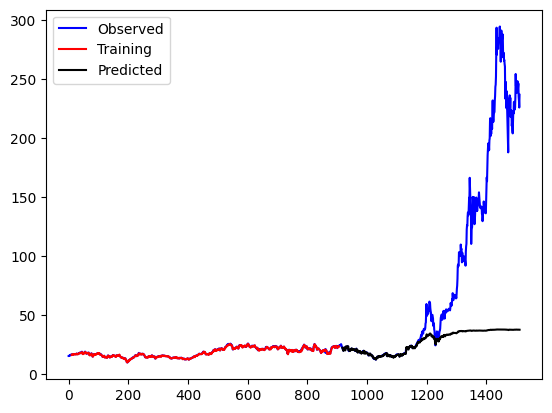

In [ ]:
# plotting
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :].flatten()
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :].flatten()
# plot
plt.plot(timeseries, c='b', label="Observed")
plt.plot(train_plot, c='r', label="Training")
plt.plot(test_plot, c='black', label="Predicted")
plt.legend();
plt.show()


## Attention LSTM

In [ ]:
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size + input_size, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Pass the input through the LSTM
        lstm_out, _ = self.lstm(x)

        # Concatenate the LSTM output and the input
        concat = torch.cat((lstm_out, x), dim=2)

        # Apply the attention layer
        attention_weights = torch.softmax(self.attention(concat), dim=1)

        # Multiply the attention weights with the LSTM output
        weighted_output = torch.bmm(attention_weights.unsqueeze(1).squeeze(3), lstm_out)

        # Apply the dropout layer
        dropped = self.dropout(weighted_output)

        # Apply the final linear layer
        output = self.linear(dropped)

        return output

# train on TSLA data only
n_epochs = 500
for ticker in ["TSLA"]:
    # create new model
    model = AttentionLSTM(1, 50, 3)
    # training and batching setup
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    # train-test split for time series of ticker
    timeseries = price_data[ticker][1]
    train_size = int(len(timeseries) * 0.60)
    test_size = len(timeseries) - train_size
    train, test = timeseries[:train_size], timeseries[train_size:]

    # create batched data set
    lookback = 30
    X_train, y_train = create_dataset(train.values, lookback=lookback)
    X_test, y_test = create_dataset(test.values, lookback=lookback)
    loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
    print("> Model for {} created".format(ticker))

    # Train the model
    train_error = []
    test_error = []
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()

        for X_batch, y_batch in loader:
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        if epoch % 10 != 0:
          continue
        model.eval()
        with torch.no_grad():
          y_pred = model(X_train)
          train_rmse = np.sqrt(loss_fn(y_pred, y_train))
          y_pred = model(X_test)
          test_rmse = np.sqrt(loss_fn(y_pred, y_test))
          print("Stock = %s, Epoch %d: train RMSE %.4f, test RMSE %.4f" % (ticker, epoch, train_rmse, test_rmse))
        train_error.append(train_rmse.item())
        test_error.append(test_rmse.item())
    # Save the model and errors after training
    with open(f".../models/loss/{ticker}_AttentionLSTM_train.pkl", 'wb') as f:
        pickle.dump(train_error, f)
    with open(f".../models/loss/{ticker}_AttentionLSTM_test.pkl", 'wb') as f:
        pickle.dump(test_error, f)
    print("Loss Information Saved")

# Save the model weights
torch.save(model.state_dict(), f".../models/{ticker}_AttentionLSTM.pt")


> Model for TSLA created


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 30, 1])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 30, 1])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([877, 30, 1])) that is different to the input size (torch.Size([877, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size

Stock = TSLA, Epoch 0: train RMSE 10.4317, test RMSE 108.7244
Stock = TSLA, Epoch 10: train RMSE 3.6959, test RMSE 102.6148
Stock = TSLA, Epoch 20: train RMSE 1.3909, test RMSE 100.6562
Stock = TSLA, Epoch 30: train RMSE 1.2212, test RMSE 99.4860
Stock = TSLA, Epoch 40: train RMSE 1.1349, test RMSE 98.9479
Stock = TSLA, Epoch 50: train RMSE 1.1062, test RMSE 98.7278
Stock = TSLA, Epoch 60: train RMSE 1.1567, test RMSE 98.7502
Stock = TSLA, Epoch 70: train RMSE 1.1076, test RMSE 98.7682
Stock = TSLA, Epoch 80: train RMSE 1.1048, test RMSE 98.3920
Stock = TSLA, Epoch 90: train RMSE 1.1024, test RMSE 98.3931
Stock = TSLA, Epoch 100: train RMSE 1.1127, test RMSE 98.3342
Stock = TSLA, Epoch 110: train RMSE 1.1372, test RMSE 98.2611
Stock = TSLA, Epoch 120: train RMSE 1.1333, test RMSE 98.2548
Stock = TSLA, Epoch 130: train RMSE 1.0987, test RMSE 98.3205
Stock = TSLA, Epoch 140: train RMSE 1.0998, test RMSE 98.1624
Stock = TSLA, Epoch 150: train RMSE 1.3647, test RMSE 97.9544
Stock = TSLA, E

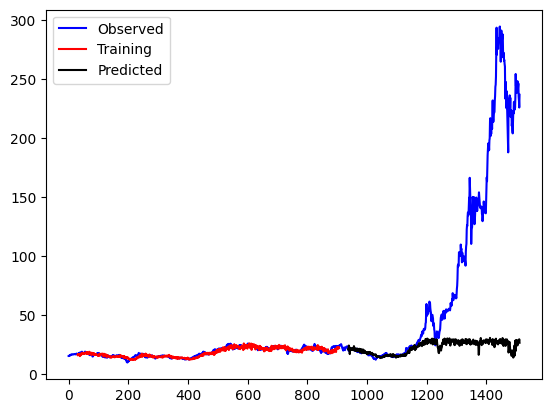

In [ ]:
# plotting
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :].flatten()
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :].flatten()
# plot
plt.plot(timeseries, c='b', label="Observed")
plt.plot(train_plot, c='r', label="Training")
plt.plot(test_plot, c='black', label="Predicted")
plt.legend();
plt.show()


## Reporting

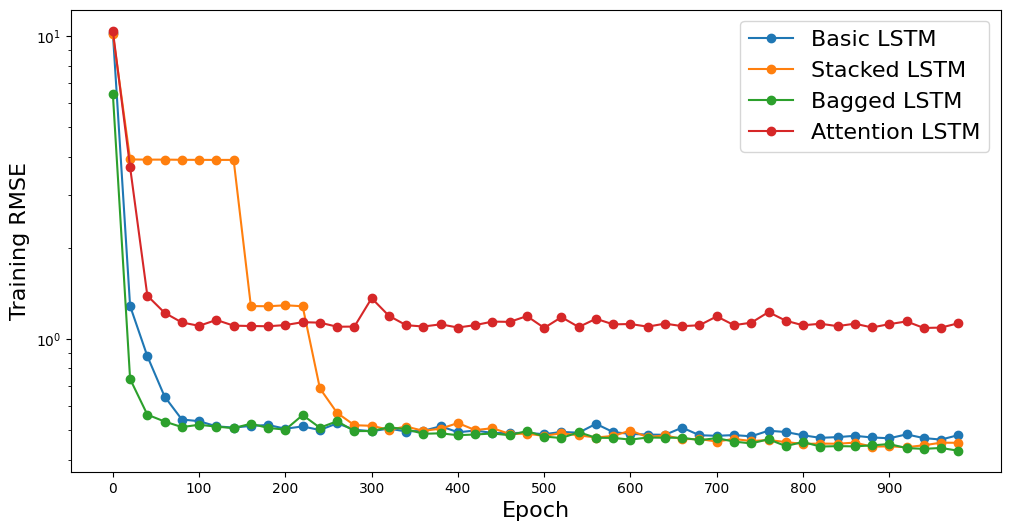

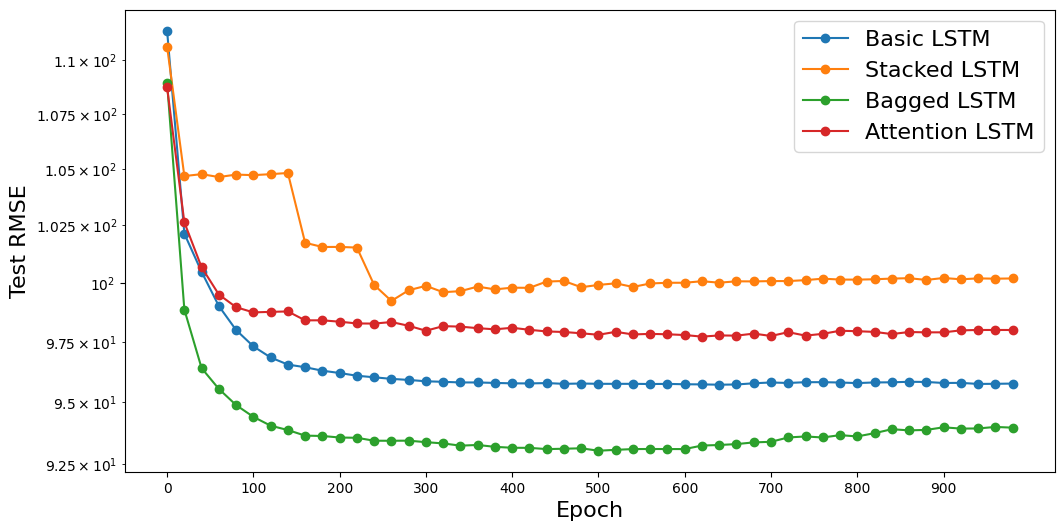

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Load the errors for all models
train_error_basic_lstm = pickle.load(open(f".../models/loss/TSLA_BasicLSTM_train.pkl", 'rb'))
test_error_basic_lstm = pickle.load(open(f".../models/loss/TSLA_BasicLSTM_test.pkl", 'rb'))
train_error_stacked_lstm = pickle.load(open(f".../models/loss/TSLA_StackedLSTM_train.pkl", 'rb'))
test_error_stacked_lstm = pickle.load(open(f".../models/loss/TSLA_StackedLSTM_test.pkl", 'rb'))
train_error_bagged_lstm = pickle.load(open(f".../models/loss/TSLA_BaggedLSTM_train.pkl", 'rb'))
test_error_bagged_lstm = pickle.load(open(f".../models/loss/TSLA_BaggedLSTM_test.pkl", 'rb'))
train_error_attention_lstm = pickle.load(open(f".../models/loss/TSLA_AttentionLSTM_train.pkl", 'rb'))
test_error_attention_lstm = pickle.load(open(f".../models/loss/TSLA_AttentionLSTM_test.pkl", 'rb'))

# Plot the training error
plt.figure(figsize=(12, 6))
plt.semilogy(range(len(train_error_basic_lstm)), train_error_basic_lstm, 'o-', label="Basic LSTM")
plt.semilogy(range(len(train_error_stacked_lstm)), train_error_stacked_lstm, 'o-', label="Stacked LSTM")
plt.semilogy(range(len(train_error_bagged_lstm)), train_error_bagged_lstm, 'o-', label="Bagged LSTM")
plt.semilogy(range(len(train_error_attention_lstm)), train_error_attention_lstm, 'o-', label="Attention LSTM")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Training RMSE", fontsize=16)
plt.xticks(range(50)[::5], range(0, 1000, 20)[::5])
plt.legend(fontsize=16)
plt.savefig("./train_loss.png", dpi=200, bbox_inches="tight")


# Plot the test error
plt.figure(figsize=(12, 6))
plt.semilogy(range(len(test_error_basic_lstm)), test_error_basic_lstm, 'o-', label="Basic LSTM")
plt.semilogy(range(len(test_error_stacked_lstm)), test_error_stacked_lstm, 'o-', label="Stacked LSTM")
plt.semilogy(range(len(test_error_bagged_lstm)), test_error_bagged_lstm, 'o-', label="Bagged LSTM")
plt.semilogy(range(len(test_error_attention_lstm)), test_error_attention_lstm, 'o-', label="Attention LSTM")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Test RMSE", fontsize=16)
plt.xticks(range(50)[::5], range(0, 1000, 20)[::5])
plt.legend(fontsize=16)
plt.savefig("./test_loss.png", dpi=200, bbox_inches="tight")


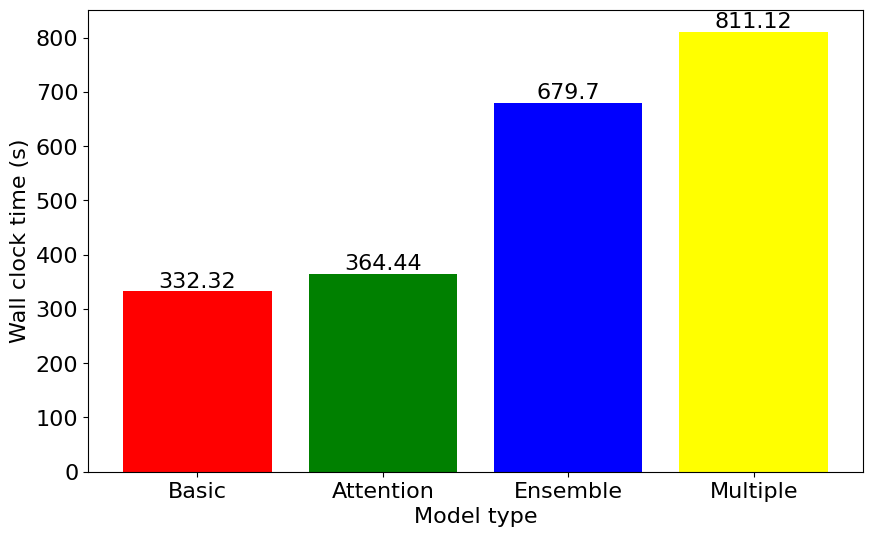

In [ ]:
import matplotlib.pyplot as plt

# Data to plot
data = [332.32, 364.44, 679.7, 811.12]

# X-axis labels
xlabels = ["Basic", "Attention", "Ensemble", "Multiple"]

# Colors for the bars
colors = ["red", "green", "blue", "yellow"]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar plot
ax.bar(xlabels, data, color=colors)

# Add the exact numbers on top of each bar
for i, value in enumerate(data):
    ax.annotate(str(value), xy=(i, value), ha='center', va='bottom', fontsize=16)

# Set the labels and title
ax.set_xlabel("Model type", fontsize=16)
ax.set_ylabel("Wall clock time (s)", fontsize=16)

# Set the font size of the tick labels
ax.tick_params(axis="both", which="major", labelsize=16)

# Show the plot
plt.savefig("./lstm_runtime.png", dpi=200, bbox_inches="tight")
